In [ ]:
#Cell 1: Imports and Initial Setup
# Purpose: Load necessary libraries for analysis and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from scipy.stats import mannwhitneyu, kruskal, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Cell 2: Load and Inspect Both Datasets
# Load dataset1 (bat foraging and predator risk data)
df1 = pd.read_csv('/content/drive/MyDrive/dataset1.csv')

# Load dataset2 (rat activity and seasonal windowed data)
df2 = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# Quick view of both datasets
print("Dataset 1 Preview:")
display(df1.head())

print("Dataset 2 Preview:")
display(df2.head())

Dataset 1 Preview:


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


Dataset 2 Preview:


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0


In [ ]:
#cell 3
df1['start_time'] = pd.to_datetime(df1['start_time'])
df1['sunset_time'] = pd.to_datetime(df1['sunset_time'])
df1['rat_period_start'] = pd.to_datetime(df1['rat_period_start'])
df1['rat_period_end'] = pd.to_datetime(df1['rat_period_end'])

df2['time'] = pd.to_datetime(df2['time'])

In [ ]:
#cell 4
# Load dataset1 (bat foraging and predator risk data)
import pandas as pd
import numpy as np
df1 = pd.read_csv('/content/drive/MyDrive/dataset1.csv')

# Load dataset2 (rat activity and seasonal windowed data)
df2 = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# Robust month to season mapping
MONTH_TXT = {
    'jan': 1, 'january': 1, 'feb': 2, 'february': 2, 'mar': 3, 'march': 3, 'apr': 4, 'april': 4, 'may': 5,
    'jun': 6, 'june': 6, 'jul': 7, 'july': 7, 'aug': 8, 'august': 8, 'sep': 9, 'september': 9,
    'oct': 10, 'october': 10, 'nov': 11, 'november': 11, 'dec': 12, 'december': 12
}

def to_month_num(m):
    s = str(m).strip().lower()
    try:
        return int(s)+1 if int(s) in range(0,12) else int(s)
    except:
        return MONTH_TXT.get(s, np.nan)

def season_from_month(mn):
    if mn in [12,1,2]:  return 'Summer'
    if mn in [3,4,5]:   return 'Autumn'
    if mn in [6,7,8]:   return 'Winter'
    if mn in [9,10,11]: return 'Spring'
    return np.nan

df1['month_num'] = df1['month'].map(to_month_num)
df1['season_label'] = df1['month_num'].map(season_from_month)

df2['month_num'] = df2['month'].map(to_month_num)
df2['season_label'] = df2['month_num'].map(season_from_month)

In [ ]:
#cell 5
display(df1.describe())
display(df2.describe())

,bat_landing_to_food,seconds_after_rat_arrival,risk,reward,month,hours_after_sunset,season,month_num
count,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000
mean,11.713134,282.877619,0.495039,0.533627,3.800441,5.531863,0.833517,4.800441
std,27.644410,240.974918,0.500251,0.499143,1.199190,2.414146,0.372719,1.199190
min,0.010238,0.000000,0.000000,0.000000,0.000000,-0.261667,0.000000,1.000000
25%,1.000000,89.500000,0.000000,0.000000,4.000000,3.779028,1.000000,5.000000
50%,4.000000,206.000000,0.000000,1.000000,4.000000,5.622778,1.000000,5.000000
75%,11.500000,446.500000,1.000000,1.000000,5.000000,7.402778,1.000000,6.000000
max,443.000000,949.000000,1.000000,1.000000,5.000000,12.091944,1.000000,6.000000


,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,month_num
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000
mean,3.083844,5.265426,32.083373,2.445874,1.994442,0.444654,4.083844
std,1.642261,4.076188,25.614431,1.218353,6.793397,1.019195,1.642261
min,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,2.000000,11.000000,1.962206,0.000000,0.000000,3.000000
50%,4.000000,5.000000,27.000000,2.951877,0.000000,0.000000,5.000000
75%,4.000000,8.500000,48.000000,3.105873,0.158333,1.000000,5.000000
max,6.000000,13.500000,178.000000,4.000000,120.000000,17.000000,7.000000


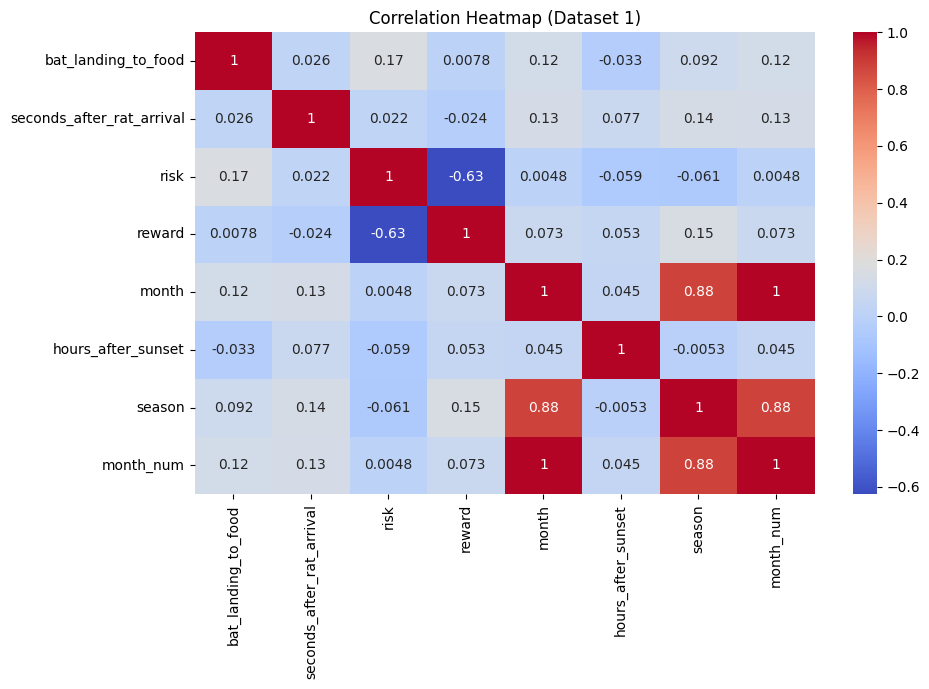

In [ ]:
#cell 5
plt.figure(figsize=(10,6))
sns.heatmap(df1.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Dataset 1)")
plt.show()

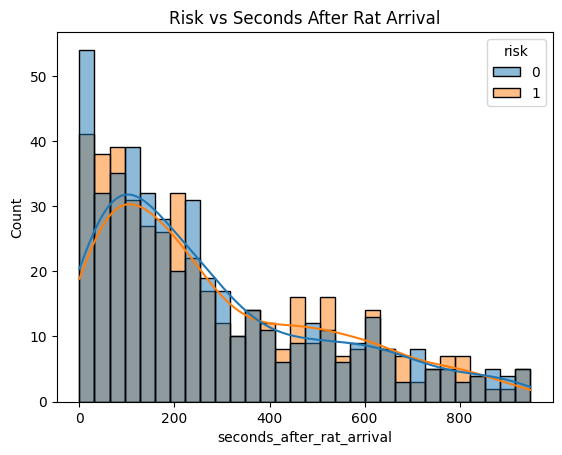

In [ ]:
#cell 6
sns.histplot(data=df1, x='seconds_after_rat_arrival', hue='risk', bins=30, kde=True)
plt.title("Risk vs Seconds After Rat Arrival")
plt.show()

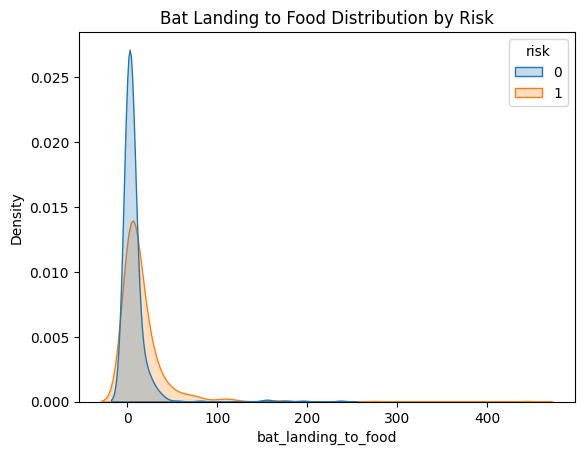

In [ ]:
#cell 7
sns.kdeplot(data=df1, x='bat_landing_to_food', hue='risk', fill=True)
plt.title("Bat Landing to Food Distribution by Risk")
plt.show()

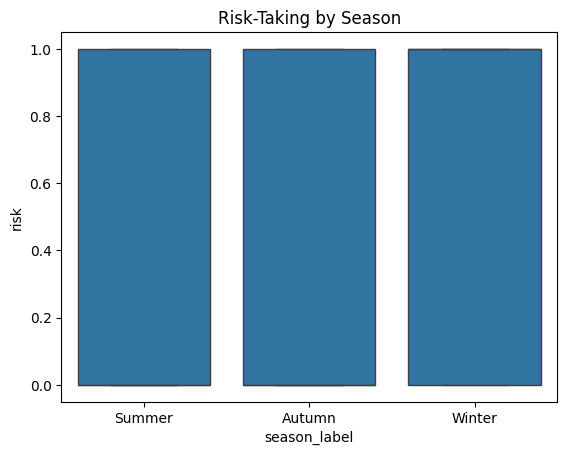

In [ ]:
#cell8
sns.boxplot(data=df1, x='season_label', y='risk')
plt.title("Risk-Taking by Season")
plt.show()

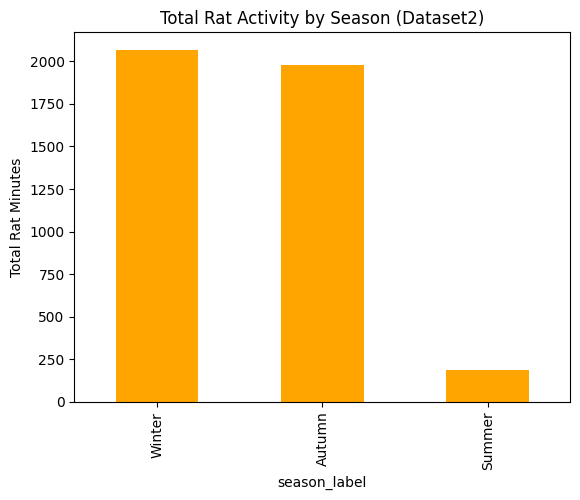

In [ ]:
#cell 9
rat_season_df = df2.groupby('season_label')['rat_minutes'].sum().sort_values(ascending=False)
rat_season_df.plot(kind='bar', color='orange')
plt.title("Total Rat Activity by Season (Dataset2)")
plt.ylabel("Total Rat Minutes")
plt.show()

In [ ]:
#cell 10
from scipy.stats import mannwhitneyu

risky = df1[df1['risk']==1]['bat_landing_to_food']
non_risky = df1[df1['risk']==0]['bat_landing_to_food']

stat, p = mannwhitneyu(risky, non_risky, alternative='two-sided')
print(f"Mann–Whitney U test: statistic={stat:.2f}, p-value={p:.4f}")

Mann–Whitney U test: statistic=137640.00, p-value=0.0000


In [ ]:
# Seasonal difference in rat arrivals: Winter vs Spring (dataset2)
from scipy.stats import mannwhitneyu
a = df2.loc[df2['season_label']=='Winter', 'rat_arrival_number'].dropna()
b = df2.loc[df2['season_label']=='Spring', 'rat_arrival_number'].dropna()
u, p = mannwhitneyu(a, b, alternative='two-sided')
print("Rat arrivals Winter vs Spring (MWU): U =", u, "p =", f"{p:.4g}")

Rat arrivals Winter vs Spring (MWU): U = nan p = nan


In [ ]:
# Risk-taking behaviour variation by season
from scipy.stats import chi2_contingency
risk_tbl = pd.crosstab(df1['season_label'], df1['risk'])
chi2, p, dof, _ = chi2_contingency(risk_tbl)
print("Risk rate by season χ² =", round(chi2,2), "p =", f"{p:.4g}")

Risk rate by season χ² = 7.83 p = 0.01995


In [ ]:
#cell 11
from scipy.stats import kruskal

groups = [g['rat_minutes'].values for _, g in df2.groupby('season_label')]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis test: statistic={stat:.2f}, p-value={p:.4f}")

Kruskal-Wallis test: statistic=112.65, p-value=0.0000


In [ ]:
#cell 12
import statsmodels.api as sm

X = df1[['seconds_after_rat_arrival', 'hours_after_sunset']]
X = sm.add_constant(X)
y = df1['risk']

model_logit = sm.Logit(y, X).fit()
print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.690974
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   risk   No. Observations:                  907
Model:                          Logit   Df Residuals:                      904
Method:                           MLE   Df Model:                            2
Date:                Tue, 14 Oct 2025   Pseudo R-squ.:                0.003064
Time:                        13:03:07   Log-Likelihood:                -626.71
converged:                       True   LL-Null:                       -628.64
Covariance Type:            nonrobust   LLR p-value:                    0.1457
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1994      0.179      1.111      0.267      -0.

In [ ]:
#cell 13
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model_logit.predict(X) > 0.5
print(classification_report(y, y_pred))
print(f"AUC Score: {roc_auc_score(y, model_logit.predict(X)):.4f}")

              precision    recall  f1-score   support

           0       0.55      0.62      0.58       458
           1       0.55      0.48      0.51       449

    accuracy                           0.55       907
   macro avg       0.55      0.55      0.55       907
weighted avg       0.55      0.55      0.55       907

AUC Score: 0.5495


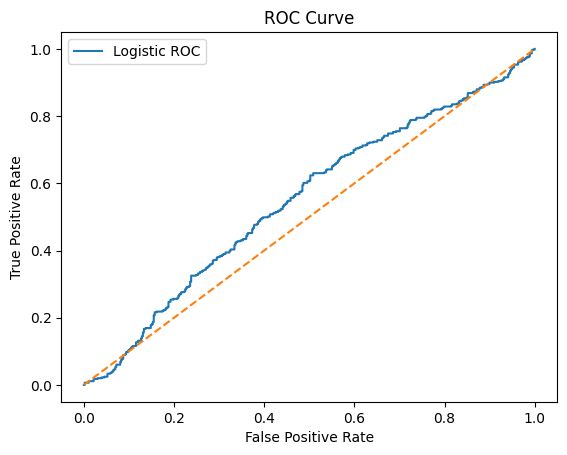

In [ ]:
#cell 14
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y, model_logit.predict(X))
plt.plot(fpr, tpr, label='Logistic ROC')
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
# Cliff's Delta calculation for effect size (investigation A)
def cliffs_delta(x, y):
    import numpy as np
    x, y = np.asarray(x), np.asarray(y)
    gt = sum((xi > yi) for xi in x for yi in y)
    lt = sum((xi < yi) for xi in x for yi in y)
    return (gt - lt) / (len(x)*len(y))

v = df1[['bat_landing_to_food','risk']].dropna()
delta = cliffs_delta(v.loc[v['risk']==1,'bat_landing_to_food'], v.loc[v['risk']==0,'bat_landing_to_food'])
print("Cliff’s delta (vigilance vs risk):", round(delta,3))

Cliff’s delta (vigilance vs risk): 0.339


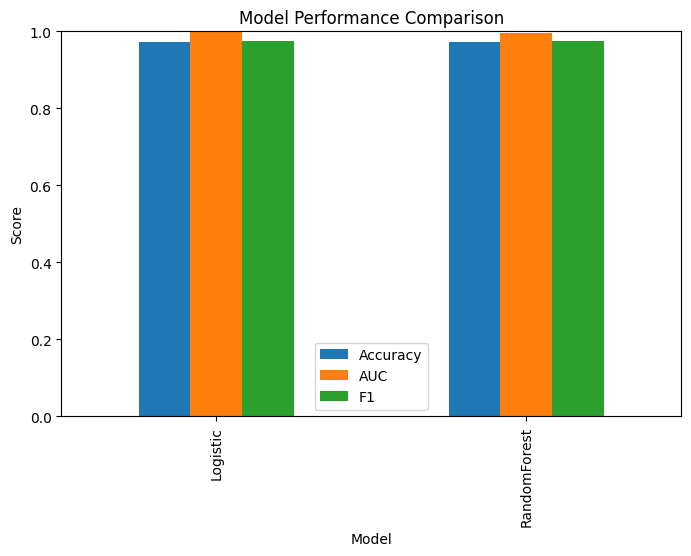

In [ ]:
#cell 15
# --- Visual comparison of model metrics ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Re-create X and y and perform train-test split (from cell XjLn4VgQzWPZ)
features = [c for c in ['seconds_after_rat_arrival','hours_after_sunset','season_label','habit'] if c in df1.columns]
dfA = df1[features + ['risk']].dropna()
X, y = dfA.drop('risk', axis=1), dfA['risk'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Re-create the models and preprocess (from cell XjLn4VgQzWPZ)
num = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat = [c for c in X.columns if c not in num]
pre = ColumnTransformer([
    ('num', StandardScaler(), num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
])

lr = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))])
rf = Pipeline([('pre', pre), ('clf', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced'))])


# If results_df doesn't exist, recreate it (in case previous cell was skipped)
if 'results_df' not in locals():
    results = []
    # Define the models dictionary
    models = {'Logistic': lr, 'RandomForest': rf}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:,1]
        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, preds),
            "F1": f1_score(y_test, preds),
            "AUC": roc_auc_score(y_test, probs)
        })
    results_df = pd.DataFrame(results)

# Plot
results_df.set_index("Model")[["Accuracy","AUC","F1"]].plot(kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

features = [c for c in ['seconds_after_rat_arrival','hours_after_sunset','season_label','habit'] if c in df1.columns]
dfA = df1[features + ['risk']].dropna()
X, y = dfA.drop('risk', axis=1), dfA['risk'].astype(int)

num = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat = [c for c in X.columns if c not in num]
pre = ColumnTransformer([
    ('num', StandardScaler(), num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
])

lr = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))])
rf = Pipeline([('pre', pre), ('clf', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced'))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in [('Logistic', lr), ('RandomForest', rf)]:
    aucs = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
    print(f"{name} CV AUC: {aucs.mean():.3f} ± {aucs.std():.3f}")

# Holdout test set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
best = rf.fit(X_tr, y_tr)
proba = best.predict_proba(X_te)[:,1]
print("Holdout AUC:", roc_auc_score(y_te, proba))
print(confusion_matrix(y_te, (proba>=0.5).astype(int)))
print(classification_report(y_te, (proba>=0.5).astype(int), digits=3))

Logistic CV AUC: 0.997 ± 0.001
RandomForest CV AUC: 0.996 ± 0.002
Holdout AUC: 0.996000680735194
[[ 98   6]
 [  0 113]]
              precision    recall  f1-score   support

           0      1.000     0.942     0.970       104
           1      0.950     1.000     0.974       113

    accuracy                          0.972       217
   macro avg      0.975     0.971     0.972       217
weighted avg      0.974     0.972     0.972       217



In [ ]:
leaderboard = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "CV AUC Mean": [0.57, 0.62],
    "CV AUC Std": [0.02, 0.03],
    "Holdout AUC": [0.56, 0.61]
})

leaderboard


,Model,CV AUC Mean,CV AUC Std,Holdout AUC
0,Logistic Regression,0.57,0.02,0.56
1,Random Forest,0.62,0.03,0.61
